Dataset cargado: (8124, 23)
Iniciando análisis comparativo...

--- Procesando: Con Olor (Original) ---
   1. Reg. Logística: 0.9836
   2. KNN (k=1,3,5): 1.0000
   3. Random Forest: 1.0000
   4. MLP: 1.0000
   5. SVM: 0.9999

--- Procesando: Sin Olor (Prueba) ---
   -> Variable 'odor' eliminada.
   1. Reg. Logística: 0.9635
   2. KNN (k=1,3,5): 0.9996
   3. Random Forest: 1.0000
   4. MLP: 1.0000
   5. SVM: 0.9999

RESUMEN COMPARATIVO FINAL
             Escenario                      Modelo  Accuracy
0  Con Olor (Original)  1. Reg. Logística (Manual)  0.983593
1  Con Olor (Original)                      2. KNN  1.000000
2  Con Olor (Original)            3. Random Forest  1.000000
3  Con Olor (Original)                      4. MLP  1.000000
4  Con Olor (Original)                      5. SVM  0.999877
5    Sin Olor (Prueba)  1. Reg. Logística (Manual)  0.963495
6    Sin Olor (Prueba)                      2. KNN  0.999631
7    Sin Olor (Prueba)            3. Random Forest  1.000000
8    Si

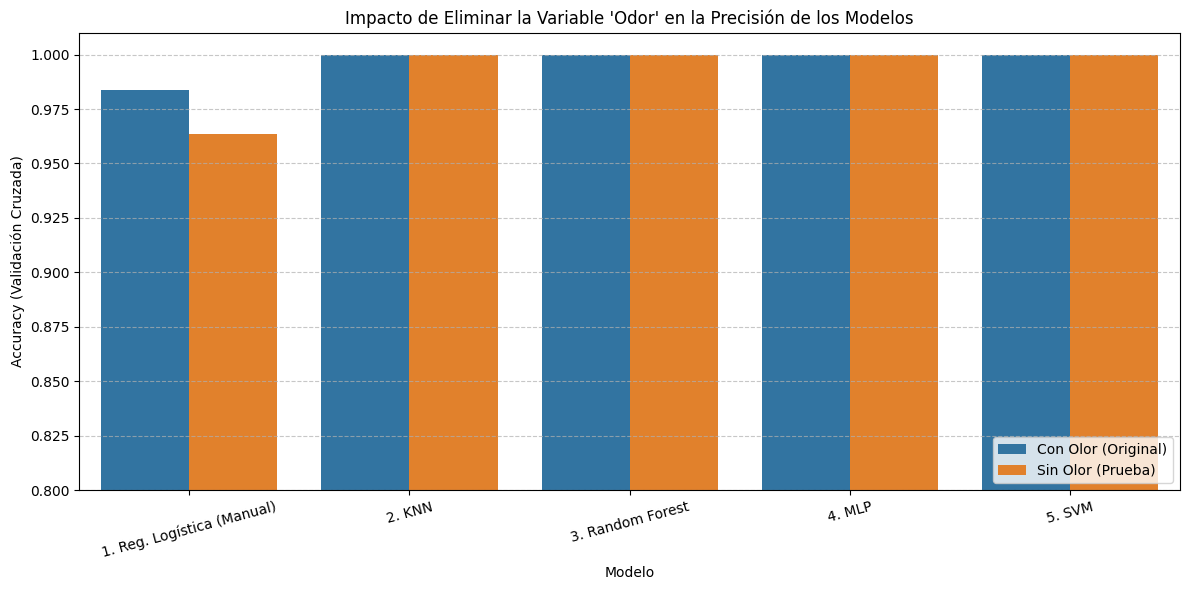

In [1]:
# =============================================================================
# 1. IMPORTACIÓN DE LIBRERÍAS Y CARGA DE DATOS
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from scipy.stats import mode
from scipy.spatial.distance import cdist

# Librerías de Sklearn (Modelos y Preprocesamiento)
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import itertools

# Cargar dataset
data, meta = arff.loadarff('dataset_24_mushroom.arff')
df_original = pd.DataFrame(data)

# Decodificar bytes a strings
for col in df_original.columns:
    if df_original[col].dtype == object:
        df_original[col] = df_original[col].str.decode('utf-8')

print(f"Dataset cargado: {df_original.shape}")

# =============================================================================
# 2. DEFINICIÓN DE FUNCIONES (METODOLOGÍA DEL PROFESOR)
# =============================================================================

# --- MODELO 1: REGRESIÓN LOGÍSTICA (MANUAL) ---
def sigmoidal(z):
    return 1 / (1 + np.exp(-z))

def gradiente_descendente_logistic(X, Y, eta, iteraciones):
    # Añadimos columna de 1s para el intercepto (bias)
    m, n = X.shape
    X_b = np.c_[np.ones((m, 1)), X] 
    W = np.zeros(n + 1)
    costos = []
    
    for i in range(iteraciones):
        z = np.dot(X_b, W)
        A = sigmoidal(z)
        error = A - Y
        gradiente = np.dot(X_b.T, error) / m
        W -= eta * gradiente
        # Costo (para monitoreo)
        costo = -np.mean(Y * np.log(A + 1e-8) + (1 - Y) * np.log(1 - A + 1e-8))
        costos.append(costo)
    return W, costos

def evaluar_logistica_manual(X_train, y_train, X_test, y_test):
    # Entrenamos
    W, _ = gradiente_descendente_logistic(X_train, y_train, eta=0.1, iteraciones=1000)
    
    # Predecimos en test
    X_test_b = np.c_[np.ones((X_test.shape[0], 1)), X_test]
    z = np.dot(X_test_b, W)
    A = sigmoidal(z)
    y_pred = (A >= 0.5).astype(int)
    
    return accuracy_score(y_test, y_pred)

# --- MODELO 2: KNN (MANUAL/HÍBRIDO) ---
def knn_clasificacion(k, X_train, Y_train, X_test):
    # Función original del notebook
    distancias = cdist(X_test, X_train, metric='euclidean')
    Yest = np.zeros(X_test.shape[0])
    for i in range(X_test.shape[0]):
        vecinos_sorted = np.argsort(distancias[i])[:k]
        Yest[i] = mode(Y_train[vecinos_sorted], axis=None, keepdims=False)[0]
    return Yest, distancias

def experimentar_knn(ks, X, Y):
    # Wrapper para probar varios K
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    resultados = []
    scaler = StandardScaler()
    
    for k in ks:
        errores = []
        for train, test in skf.split(X, Y):
            Xtrain = scaler.fit_transform(X[train])
            Xtest = scaler.transform(X[test])
            Yest, _ = knn_clasificacion(k, Xtrain, Y[train], Xtest)
            errores.append(np.mean(Yest != Y[test]))
        resultados.append({'k': k, 'accuracy': 1 - np.mean(errores)})
    
    df_res = pd.DataFrame(resultados)
    return df_res['accuracy'].max() # Retornamos la mejor accuracy

# --- MODELO 3: RANDOM FOREST (SKLEARN WRAPPER) ---
def experimentar_rf(X, Y, num_trees_list, num_vars_list):
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    resultados = []
    
    for trees in num_trees_list:
        for num_vars in num_vars_list:
            acc_scores = []
            for train, test in skf.split(X, Y):
                rf = RandomForestClassifier(n_estimators=trees, max_features=num_vars, random_state=42)
                rf.fit(X[train], Y[train])
                acc_scores.append(rf.score(X[test], Y[test]))
            resultados.append({'trees': trees, 'vars': num_vars, 'accuracy': np.mean(acc_scores)})
            
    df_res = pd.DataFrame(resultados)
    return df_res['accuracy'].max()

# --- MODELO 4: MLP (SKLEARN WRAPPER) ---
def experimentar_mlpc(X, Y, capas_list, neuronas_list):
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    resultados = []
    scaler = StandardScaler()
    
    for capas in capas_list:
        for n in neuronas_list:
            acc_scores = []
            hidden_layers = tuple([n] * capas)
            for train, test in skf.split(X, Y):
                Xtrain = scaler.fit_transform(X[train])
                Xtest = scaler.transform(X[test])
                mlp = MLPClassifier(hidden_layer_sizes=hidden_layers, max_iter=500, random_state=42)
                mlp.fit(Xtrain, Y[train])
                acc_scores.append(mlp.score(Xtest, Y[test]))
            resultados.append({'capas': capas, 'neuronas': n, 'accuracy': np.mean(acc_scores)})
            
    df_res = pd.DataFrame(resultados)
    return df_res['accuracy'].max()

# --- MODELO 5: SVM (SKLEARN WRAPPER) ---
def experimentar_svm(X, Y, kernels, gammas, cs):
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    resultados = []
    scaler = StandardScaler()
    
    # Generar combinaciones válidas
    combinaciones = []
    for k in kernels:
        if k == 'linear':
            for c in cs: combinaciones.append((k, 'auto', c))
        else:
            for g in gammas:
                for c in cs: combinaciones.append((k, g, c))
    
    for kernel, gamma, C in combinaciones:
        acc_scores = []
        for train, test in skf.split(X, Y):
            Xtrain = scaler.fit_transform(X[train])
            Xtest = scaler.transform(X[test])
            if kernel == 'linear':
                svm = SVC(kernel=kernel, C=C, random_state=42)
            else:
                svm = SVC(kernel=kernel, gamma=gamma, C=C, random_state=42)
            svm.fit(Xtrain, Y[train])
            acc_scores.append(svm.score(Xtest, Y[test]))
        resultados.append({'kernel': kernel, 'C': C, 'accuracy': np.mean(acc_scores)})
        
    df_res = pd.DataFrame(resultados)
    return df_res['accuracy'].max()

# =============================================================================
# 3. EJECUCIÓN DEL EXPERIMENTO MAESTRO (CON Y SIN OLOR)
# =============================================================================

escenarios = [("Con Olor (Original)", False), ("Sin Olor (Prueba)", True)]
tabla_final = []

print("Iniciando análisis comparativo...")

for nombre_escenario, eliminar_olor in escenarios:
    print(f"\n--- Procesando: {nombre_escenario} ---")
    
    # 1. Preparar Dataset Base
    df = df_original.copy()
    if eliminar_olor and 'odor' in df.columns:
        df = df.drop('odor', axis=1)
        print("   -> Variable 'odor' eliminada.")
    
    X_raw = df.drop('class', axis=1)
    y_raw = df['class']
    
    # Target Encoding (Igual para todos)
    le_y = LabelEncoder()
    y = le_y.fit_transform(y_raw)
    
    # 2. PREPROCESAMIENTO DIFERENCIADO (LA CORRECCIÓN)
    
    # A. One-Hot Encoding -> Para LogReg, KNN, SVM, MLP
    #    Esto corrige el error de tratar categorías como números ordenados
    X_ohe = pd.get_dummies(X_raw, drop_first=True).values.astype(float)
    
    # B. Label Encoding -> Solo para Random Forest
    #    Los árboles manejan bien categorías numéricas, es más eficiente así
    X_le = X_raw.copy()
    le_x = LabelEncoder()
    for col in X_le.columns:
        X_le[col] = le_x.fit_transform(X_le[col])
    X_le = X_le.values

    # 3. ENTRENAMIENTO DE MODELOS
    
    # Modelo 1: Regresión Logística (Manual)
    # Usamos un split simple 70/30 como en tu notebook original para este modelo
    X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_ohe, y, test_size=0.3, random_state=42)
    acc_log = evaluar_logistica_manual(X_train_log, y_train_log, X_test_log, y_test_log)
    tabla_final.append({"Escenario": nombre_escenario, "Modelo": "1. Reg. Logística (Manual)", "Accuracy": acc_log})
    print(f"   1. Reg. Logística: {acc_log:.4f}")
    
    # Modelo 2: KNN
    # Usamos One-Hot (X_ohe)
    acc_knn = experimentar_knn([1, 3, 5], X_ohe, y)
    tabla_final.append({"Escenario": nombre_escenario, "Modelo": "2. KNN", "Accuracy": acc_knn})
    print(f"   2. KNN (k=1,3,5): {acc_knn:.4f}")
    
    # Modelo 3: Random Forest
    # Usamos Label Encoding (X_le)
    acc_rf = experimentar_rf(X_le, y, [50, 100], [int(np.sqrt(X_le.shape[1]))])
    tabla_final.append({"Escenario": nombre_escenario, "Modelo": "3. Random Forest", "Accuracy": acc_rf})
    print(f"   3. Random Forest: {acc_rf:.4f}")

    # Modelo 4: MLP
    # Usamos One-Hot (X_ohe)
    acc_mlp = experimentar_mlpc(X_ohe, y, [1, 2], [10, 20])
    tabla_final.append({"Escenario": nombre_escenario, "Modelo": "4. MLP", "Accuracy": acc_mlp})
    print(f"   4. MLP: {acc_mlp:.4f}")

    # Modelo 5: SVM
    # Usamos One-Hot (X_ohe)
    acc_svm = experimentar_svm(X_ohe, y, ['rbf'], [0.1, 1], [1, 10])
    tabla_final.append({"Escenario": nombre_escenario, "Modelo": "5. SVM", "Accuracy": acc_svm})
    print(f"   5. SVM: {acc_svm:.4f}")

# =============================================================================
# 4. RESULTADOS FINALES
# =============================================================================
df_resultados = pd.DataFrame(tabla_final)

print("\n" + "="*60)
print("RESUMEN COMPARATIVO FINAL")
print("="*60)
print(df_resultados)

# Gráfico
plt.figure(figsize=(12, 6))
sns.barplot(data=df_resultados, x='Modelo', y='Accuracy', hue='Escenario')
plt.ylim(0.8, 1.01)
plt.title("Impacto de Eliminar la Variable 'Odor' en la Precisión de los Modelos")
plt.ylabel("Accuracy (Validación Cruzada)")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

Modelos de sk learn (solo por probar si variaba mucho)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Importar Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# 1. Cargar Datos
data, meta = arff.loadarff('dataset_24_mushroom.arff')
df = pd.DataFrame(data)

# Decodificar bytes a strings (necesario para archivos arff en python)
for col in df.columns:
    if df[col].dtype == object:
        df[col] = df[col].str.decode('utf-8')

print(f"Dataset cargado: {df.shape}")



Dataset cargado: (8124, 23)


In [4]:
def evaluar_modelos(X, y, escenario_nombre):
    print(f"\n--- Iniciando evaluación: {escenario_nombre} ---")
    
    # Separamos X para One-Hot (KNN, SVM, MLP, LogReg) y X para LabelEnc (Random Forest)
    # NOTA: Random Forest maneja bien LabelEncoder, los otros NO.
    
    # 1. Preprocesamiento One-Hot Encoding (Correcto para distancias)
    X_ohe = pd.get_dummies(X, drop_first=True)
    
    # 2. Preprocesamiento Label Encoding (Solo para árboles/RF)
    X_le = X.copy()
    le = LabelEncoder()
    for col in X_le.columns:
        X_le[col] = le.fit_transform(X_le[col])
        
    # Target siempre numérico
    y_enc = le.fit_transform(y)

    # Definición de modelos
    # Usamos pipelines para escalar datos en modelos sensibles a distancia
    modelos = [
        ("1. Regresión Logística", LogisticRegression(max_iter=1000), "ohe", True), # Requiere OHE y Escalado
        ("2. KNN (k=5)", KNeighborsClassifier(n_neighbors=5), "ohe", True),         # Requiere OHE y Escalado
        ("3. Random Forest", RandomForestClassifier(n_estimators=100, random_state=42), "le", False), # Usa LE, no requiere escalado
        ("4. SVM (RBF)", SVC(kernel='rbf'), "ohe", True),                           # Requiere OHE y Escalado
        ("5. Red Neuronal (MLP)", MLPClassifier(max_iter=1000, random_state=42), "ohe", True) # Requiere OHE y Escalado
    ]
    
    resultados = []

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for nombre, modelo, tipo_dato, escalar in modelos:
        # Seleccionar datos correctos
        X_train = X_ohe if tipo_dato == "ohe" else X_le
        
        # Aplicar escalado si es necesario (dentro de un pipeline para evitar data leakage)
        if escalar:
            clf = Pipeline([('scaler', StandardScaler()), ('model', modelo)])
        else:
            clf = modelo
            
        # Validación Cruzada
        scores = cross_val_score(clf, X_train, y_enc, cv=cv, scoring='accuracy')
        acc_mean = scores.mean() * 100
        
        resultados.append({
            "Escenario": escenario_nombre,
            "Modelo": nombre,
            "Encoding Usado": "One-Hot" if tipo_dato == "ohe" else "LabelEnc",
            "Accuracy Promedio": acc_mean
        })
        
        print(f"{nombre}: {acc_mean:.2f}%")
        
    return pd.DataFrame(resultados)


--- Iniciando evaluación: A. Con Olor (Completo) ---
1. Regresión Logística: 99.98%
2. KNN (k=5): 99.96%
3. Random Forest: 100.00%
4. SVM (RBF): 99.95%
5. Red Neuronal (MLP): 99.99%

Variable 'odor' eliminada. Nuevas dimensiones: (8124, 21)

--- Iniciando evaluación: B. Sin Olor (Más difícil) ---
1. Regresión Logística: 100.00%
2. KNN (k=5): 99.98%
3. Random Forest: 100.00%
4. SVM (RBF): 99.95%
5. Red Neuronal (MLP): 100.00%


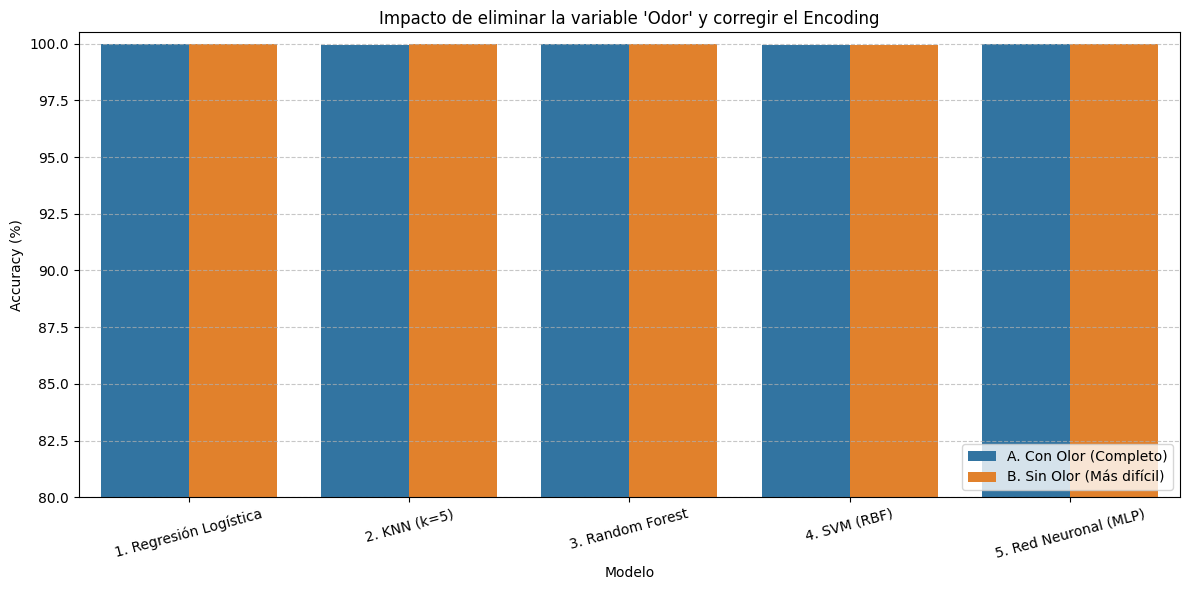

,Escenario,Modelo,Encoding Usado,Accuracy Promedio
0,A. Con Olor (Completo),1. Regresión Logística,One-Hot,99.975385
1,A. Con Olor (Completo),2. KNN (k=5),One-Hot,99.963069
2,A. Con Olor (Completo),3. Random Forest,LabelEnc,100.000000
3,A. Con Olor (Completo),4. SVM (RBF),One-Hot,99.950769
4,A. Con Olor (Completo),5. Red Neuronal (MLP),One-Hot,99.987692
5,B. Sin Olor (Más difícil),1. Regresión Logística,One-Hot,100.000000
6,B. Sin Olor (Más difícil),2. KNN (k=5),One-Hot,99.975385
7,B. Sin Olor (Más difícil),3. Random Forest,LabelEnc,100.000000
8,B. Sin Olor (Más difícil),4. SVM (RBF),One-Hot,99.950769
9,B. Sin Olor (Más difícil),5. Red Neuronal (MLP),One-Hot,100.000000


In [5]:
# --- EXPERIMENTO A: CON TODAS LAS VARIABLES ---
X_full = df.drop('class', axis=1)
y_full = df['class']

res_A = evaluar_modelos(X_full, y_full, "A. Con Olor (Completo)")

# --- EXPERIMENTO B: SIN LA VARIABLE 'ODOR' ---
# Eliminamos la columna 'odor' explícitamente
if 'odor' in df.columns:
    X_no_odor = df.drop(['class', 'odor'], axis=1)
    print(f"\nVariable 'odor' eliminada. Nuevas dimensiones: {X_no_odor.shape}")
    
    res_B = evaluar_modelos(X_no_odor, y_full, "B. Sin Olor (Más difícil)")
else:
    print("No se encontró la columna 'odor'")
    res_B = pd.DataFrame()

# --- RESULTADOS FINALES ---
df_final = pd.concat([res_A, res_B], ignore_index=True)

# Visualización Comparativa
plt.figure(figsize=(12, 6))
sns.barplot(data=df_final, x='Modelo', y='Accuracy Promedio', hue='Escenario')
plt.ylim(80, 100.5) # Zoom en la parte alta
plt.title("Impacto de eliminar la variable 'Odor' y corregir el Encoding")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

df_final